In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [2]:
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()

In [3]:
from google.colab import drive
drive.mount("/content/drive/")
!cd '/content/drive/My Drive/bird_classification/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
orig_path = '/content/drive/My Drive/bird_classification/' + '/data/bird_dataset/'

In [5]:
## For reproductibility
torch.manual_seed(2)
np.random.seed(2)
random.seed(2)

We have approximately 50 pictures of bird by species which is not enough to train a neural network I think. So I will use transfer learning

# Data : Fast way to choose the resizing interpolation

In [4]:
img = cv2.imread(orig_path + 'train_images/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0084_27034.jpg')
img.shape

(370, 500, 3)

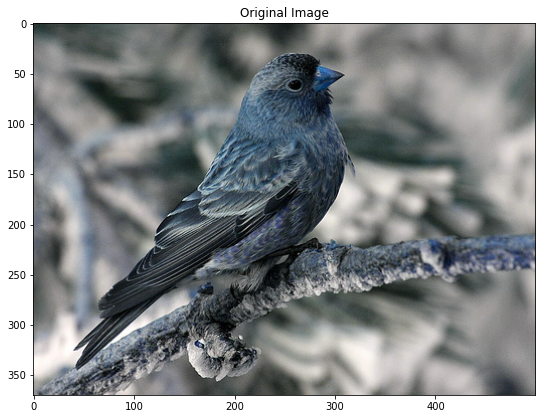

In [5]:
plt.figure(figsize=(9,9))
plt.title('Original Image')
plt.imshow(img)
plt.show()

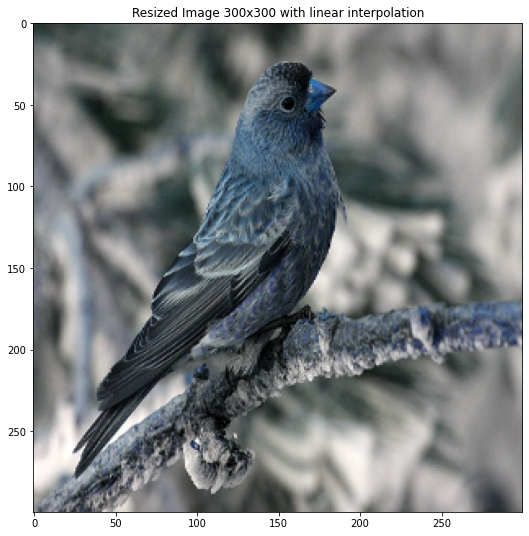

In [6]:
plt.figure(figsize=(9,9))
plt.title('Resized Image 300x300 with linear interpolation')
plt.imshow(cv2.resize(img, (300,300), interpolation=cv2.INTER_LINEAR))
plt.show()

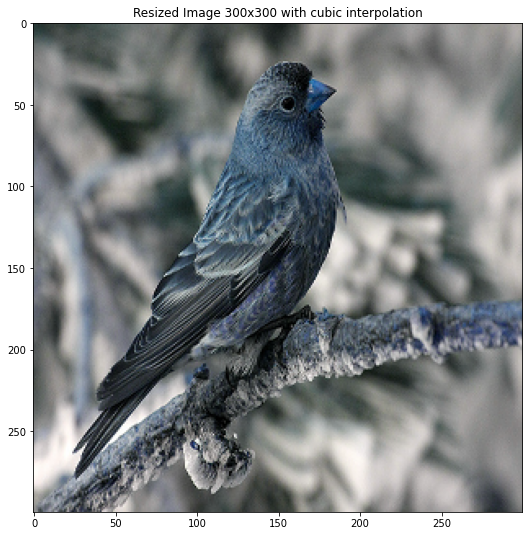

In [7]:
plt.figure(figsize=(9,9))
plt.title('Resized Image 300x300 with cubic interpolation')
plt.imshow(cv2.resize(img, (300,300), interpolation=cv2.INTER_CUBIC))
plt.show()

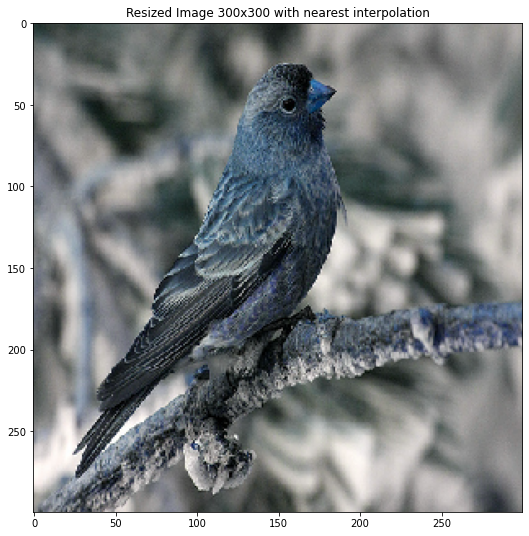

In [8]:
plt.figure(figsize=(9,9))
plt.title('Resized Image 300x300 with nearest interpolation')
plt.imshow(cv2.resize(img, (300,300), interpolation=cv2.INTER_NEAREST))
plt.show()

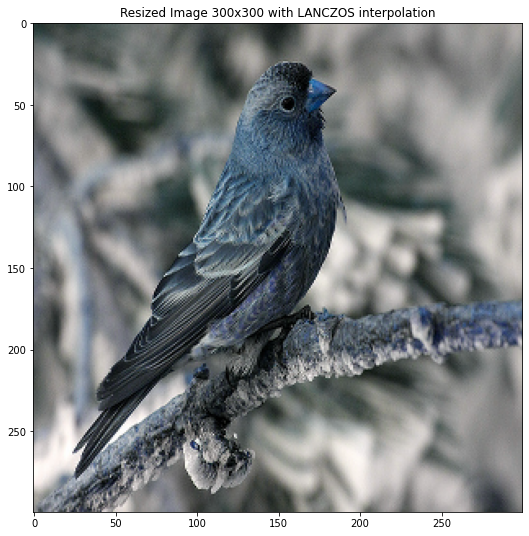

In [9]:
plt.figure(figsize=(9,9))
plt.title('Resized Image 300x300 with LANCZOS interpolation')
plt.imshow(cv2.resize(img, (300,300), interpolation=cv2.INTER_LANCZOS4))
plt.show()

I will choose the INTER CUBIC Interpolation since it's the smoothest one :)

# Baseline
I will use a classical cnn architecture & dataaugmentation

In [6]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
import torchvision.transforms as transforms


data_transforms_train = transforms.Compose([
    transforms.Resize((300, 300), interpolation=4),  ## https://pillow.readthedocs.io/en/latest/handbook/concepts.html#filters
    transforms.RandomRotation(45),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

data_transforms_val = transforms.Compose([
    transforms.Resize((300, 300), interpolation=4),  ## https://pillow.readthedocs.io/en/latest/handbook/concepts.html#filters
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [7]:
# batch_size = 32
batch_size = 16 # For ResNet
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(orig_path + '/train_images',
                         transform=data_transforms_train),
    batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(orig_path + '/val_images',
                         transform=data_transforms_val),
    batch_size=batch_size, shuffle=False)

In [84]:
nclasses = 20 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=7)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=5)
        self.conv4 = nn.Conv2d(30, 30, kernel_size=5)
        self.fc1 = nn.Linear(14*14*30, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(-1, 14*14*30)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
model = Net()
model.cuda()

In [86]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
lr = 8 * 1e-4
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=lr)

In [87]:
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
def train(epoch):
    model.train()
    correct = 0
    loss_values = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        #target = target.reshape(-1,1)
        optimizer.zero_grad()
        output = model(data)
        #print(output.shape)
        #print(target.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
        loss_values += loss.data.item()
    avg_acc = 100*correct / len(train_loader.dataset)
    avg_loss = loss_values / len(train_loader.dataset)
    print(f'Average Accuracy : {avg_acc}')
    return (avg_acc, avg_loss)
        

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.cuda(), target.cuda()
        #target = target.reshape(-1,1)
        output = model(data)
        #print(data.shape)
        #print(output.shape)
        #print(target.shape)
        # sum up batch loss
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    avg_acc = 100. * correct / len(val_loader.dataset)
    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        avg_acc))
    return (avg_acc, validation_loss)

In [ ]:
acc_train = []
loss_train = []
acc_val = []
loss_val = []
best_acc_val = 0
for epoch in range(1, 61):
    acc_t, loss_t = train(epoch)
    acc_v, loss_v = validation()
    if acc_v > best_acc_val:
      model_file = orig_path + 'model_' + str(acc_v) + '.pth'
      best_acc_val = acc_v
      torch.save(model.state_dict(), model_file)
    acc_train.append(acc_t.item())
    loss_train.append(loss_t.item())
    acc_val.append(acc_v.item())
    loss_val.append(loss_v.item())

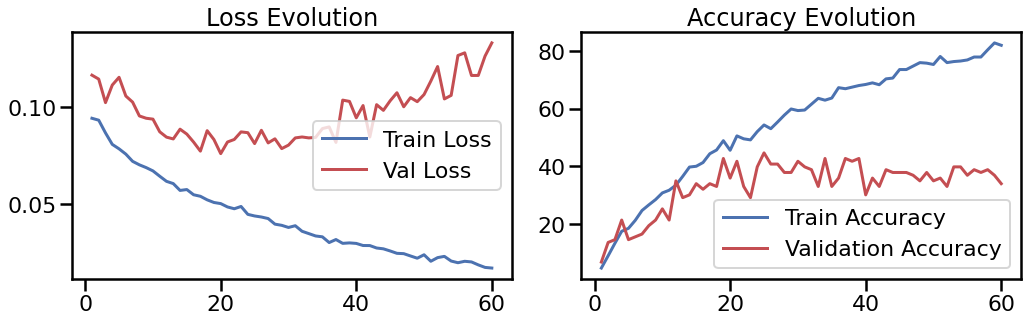

In [97]:
# Visual comparison
titles = ["Loss Evolution", "Accuracy Evolution"]
y = [[loss_train, loss_val], [acc_train, acc_val]]
label_loss = [['Train Loss', 'Val Loss'], ['Train Accuracy', 'Validation Accuracy']]
ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
steps = np.arange(1,61)
for idx, ax in enumerate(axes.flatten()):
    title = titles[idx]
    ax.plot(steps, y[idx][0], label=label_loss[idx][0], color='b')
    ax.plot(steps, y[idx][1], label=label_loss[idx][1], color='r')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()


First of all, we can clearly notice that the model overfit (train loss continue to decrease but val losse increase, same thing for the accuracy).
I'm going now to add dropout on the fully connected layer (according to this article : https://arxiv.org/pdf/1207.0580.pdf) but also the convolutional layer (according to this article : http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf)

# Baseline 2.0

In [129]:
9*9*128 / 9

1152.0

In [143]:
nclasses = 20 

class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=7)
        self.drop1 = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop2 = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=5)
        self.drop3 = nn.Dropout(0.1)
        self.conv4 = nn.Conv2d(30, 30, kernel_size=5)
        self.drop4 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(14*14*30, 128)
        self.drop5 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 20)

    def forward(self, x):
        x = self.drop1(F.relu(F.max_pool2d(self.conv1(x), 2)))
        x = self.drop2(F.relu(F.max_pool2d(self.conv2(x), 2)))
        x = self.drop3(F.relu(F.max_pool2d(self.conv3(x), 2)))
        x = self.drop4(F.relu(F.max_pool2d(self.conv4(x), 2)))
        x = x.view(-1, 14*14*30)
        x = self.drop5(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
model_1 = NewNet()
model_1.cuda()

In [162]:
param_optimizer = list(model_1.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
lr = 0.001
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=lr)

criterion = torch.nn.CrossEntropyLoss(reduction='mean')

In [8]:
def train(epoch, model):
    model.train()
    correct = 0
    loss_values = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        #target = target.reshape(-1,1)
        optimizer.zero_grad()
        output = model(data)
        #print(output.shape)
        #print(target.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
        loss_values += loss.data.item()
    avg_acc = 100*correct / len(train_loader.dataset)
    avg_loss = loss_values / len(train_loader.dataset)
    print(f'Average Accuracy : {avg_acc}')
    return (avg_acc, avg_loss)
        

def validation(model):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.cuda(), target.cuda()
        #target = target.reshape(-1,1)
        output = model(data)
        #print(data.shape)
        #print(output.shape)
        #print(target.shape)
        # sum up batch loss
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    avg_acc = 100. * correct / len(val_loader.dataset)
    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        avg_acc))
    return (avg_acc, validation_loss)

In [ ]:
acc_train = []
loss_train = []
acc_val = []
loss_val = []
best_acc_val = 0
for epoch in range(1, 81):
    acc_t, loss_t = train(epoch, model_1)
    acc_v, loss_v = validation(model_1)
    if acc_v > best_acc_val:
      model_file = orig_path + 'model_1_' + str(acc_v.item()) + '.pth'
      best_acc_val = acc_v
      torch.save(model.state_dict(), model_file)
    acc_train.append(acc_t.item())
    loss_train.append(loss_t)
    acc_val.append(acc_v.item())
    loss_val.append(loss_v)

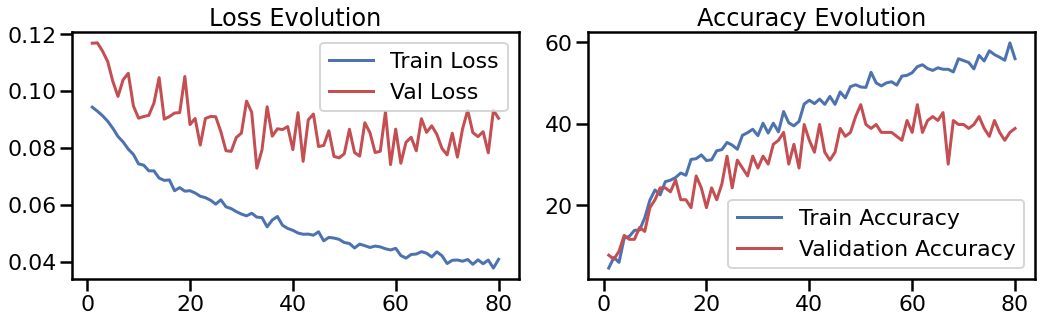

In [148]:
# Visual comparison
titles = ["Loss Evolution", "Accuracy Evolution"]
y = [[loss_train, loss_val], [acc_train, acc_val]]
label_loss = [['Train Loss', 'Val Loss'], ['Train Accuracy', 'Validation Accuracy']]
ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
steps = np.arange(1,81)
for idx, ax in enumerate(axes.flatten()):
    title = titles[idx]
    ax.plot(steps, y[idx][0], label=label_loss[idx][0], color='b')
    ax.plot(steps, y[idx][1], label=label_loss[idx][1], color='r')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()

Well we can clearly see that adding dropout lead to less overfiting. Nevertheless, Adding dropout will also increase the time of training (we need much more epoch if we hope to achieve the train accuracy of the model without dropout).

Clearly, the performance are not good enough, but it's no surprising, we don't have many pictures (so that all "possibles features" can be extracted) and we don't have enough computional power (so that the model can learn all these "possibles features"). 

Then, the idea is to use transfer learning.

# Transfer Learning

## ResNet 152 Layers 

In [ ]:
from torchvision.models import resnet152

### Not retraining resnet

In [ ]:
model_res = resnet152(pretrained=True)
for param in model_res.parameters():
  param.requires_grad = False
num_features = model_res.fc.in_features
model_res.fc = nn.Linear(num_features, 20)
model_res.cuda()

In [15]:
param_optimizer = list(model_res.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
lr = 0.001
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=lr)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
acc_train = []
loss_train = []
acc_val = []
loss_val = []
best_acc_val = 45
for epoch in range(1, 51):
    acc_t, loss_t = train(epoch, model_res)
    acc_v, loss_v = validation(model_res)
    if acc_v.item() > best_acc_val:
      model_file = orig_path + 'model_resnet_' + str(acc_v.item()) + '.pth'
      best_acc_val = acc_v
      torch.save(model_res.state_dict(), model_file)
    acc_train.append(acc_t.item())
    loss_train.append(loss_t)
    acc_val.append(acc_v.item())
    loss_val.append(loss_v)

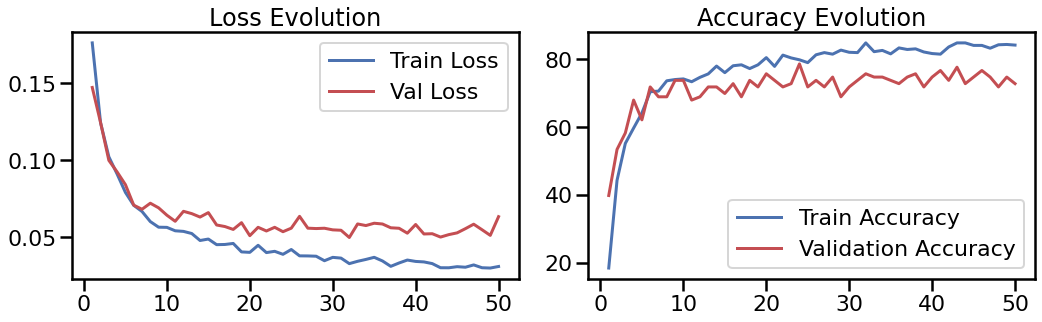

In [18]:
# Visual comparison
titles = ["Loss Evolution", "Accuracy Evolution"]
y = [[loss_train, loss_val], [acc_train, acc_val]]
label_loss = [['Train Loss', 'Val Loss'], ['Train Accuracy', 'Validation Accuracy']]
ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
steps = np.arange(1,51)
for idx, ax in enumerate(axes.flatten()):
    title = titles[idx]
    ax.plot(steps, y[idx][0], label=label_loss[idx][0], color='b')
    ax.plot(steps, y[idx][1], label=label_loss[idx][1], color='r')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()

### Retrain only some layers

In [ ]:
names = [x for x,y in list(model_res.named_parameters())]
names

I'm gonna retrain all the block corresponding to layer 4

In [ ]:
model_resnet = resnet152(pretrained=True)
i_max = len(names) - 33
i = 0
for param in model_resnet.parameters():
  if i > i_max:
    break
  i += 1
  param.requires_grad = False
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 20)
model_resnet.cuda()

In [35]:
param_optimizer = list(model_resnet.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
lr = 0.001
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=lr)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
acc_train = []
loss_train = []
acc_val = []
loss_val = []
best_acc_val = 70
for epoch in range(1, 51):
    acc_t, loss_t = train(epoch, model_resnet)
    acc_v, loss_v = validation(model_resnet)
    if acc_v.item() > best_acc_val:
      model_file = orig_path + 'model_resnet_retrained_' + str(acc_v.item()) + '.pth'
      best_acc_val = acc_v.item()
      torch.save(model_resnet.state_dict(), model_file)
    acc_train.append(acc_t.item())
    loss_train.append(loss_t)
    acc_val.append(acc_v.item())
    loss_val.append(loss_v)

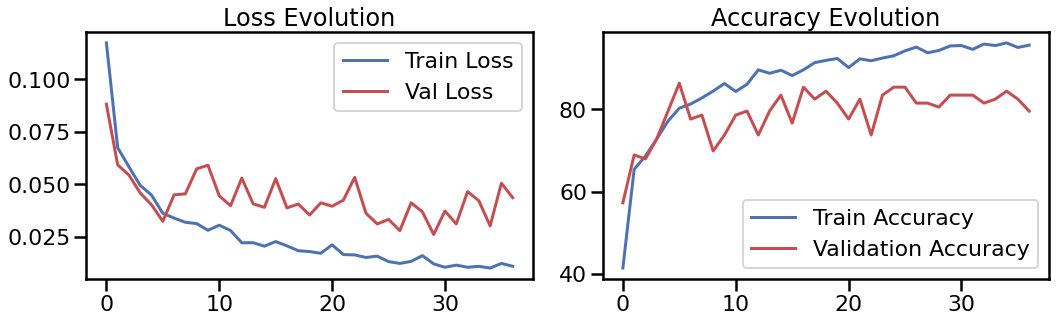

In [38]:
# Visual comparison
titles = ["Loss Evolution", "Accuracy Evolution"]
y = [[loss_train, loss_val], [acc_train, acc_val]]
label_loss = [['Train Loss', 'Val Loss'], ['Train Accuracy', 'Validation Accuracy']]
ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
steps = np.arange(0,len(loss_train))
for idx, ax in enumerate(axes.flatten()):
    title = titles[idx]
    ax.plot(steps, y[idx][0], label=label_loss[idx][0], color='b')
    ax.plot(steps, y[idx][1], label=label_loss[idx][1], color='r')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()

There is an improvment when we unfreeze some layers of the resnet model. Nevertheless, after the 10th epoch, it began to overfit.
I should reduce the number of epoch.

## Inception V3

In [39]:
from torchvision.models import inception_v3

In [ ]:
model_inception = inception_v3(pretrained=True)
for param in model_res.parameters():
  param.requires_grad = False
num_features = model_inception.fc.in_features
model_inception.fc = nn.Linear(num_features, 20)
model_inception.cuda()

In [41]:
param_optimizer = list(model_inception.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
lr = 0.001
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=lr)

criterion = torch.nn.CrossEntropyLoss()

In [57]:
def train(epoch, model):
    model.train()
    correct = 0
    loss_values = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        #target = target.reshape(-1,1)
        optimizer.zero_grad()
        output, _ = model(data)
        #print(output.shape)
        #print(target.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
        loss_values += loss.data.item()
    avg_acc = 100*correct / len(train_loader.dataset)
    avg_loss = loss_values / len(train_loader.dataset)
    print(f'Average Accuracy : {avg_acc}')
    return (avg_acc, avg_loss)
        

def validation(model):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.cuda(), target.cuda()
        #target = target.reshape(-1,1)
        output = model(data)
        #print(data.shape)
        #print(output.shape)
        #print(target.shape)
        # sum up batch loss
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    avg_acc = 100. * correct / len(val_loader.dataset)
    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        avg_acc))
    return (avg_acc, validation_loss)

In [ ]:
acc_train = []
loss_train = []
acc_val = []
loss_val = []
best_acc_val = 70
for epoch in range(1, 26):
    acc_t, loss_t = train(epoch, model_inception)
    acc_v, loss_v = validation(model_inception)
    if acc_v.item() > best_acc_val:
      model_file = orig_path + 'model_inception_' + str(acc_v.item()) + '.pth'
      best_acc_val = acc_v.item()
      torch.save(model_inception.state_dict(), model_file)
    acc_train.append(acc_t.item())
    loss_train.append(loss_t)
    acc_val.append(acc_v.item())
    loss_val.append(loss_v)

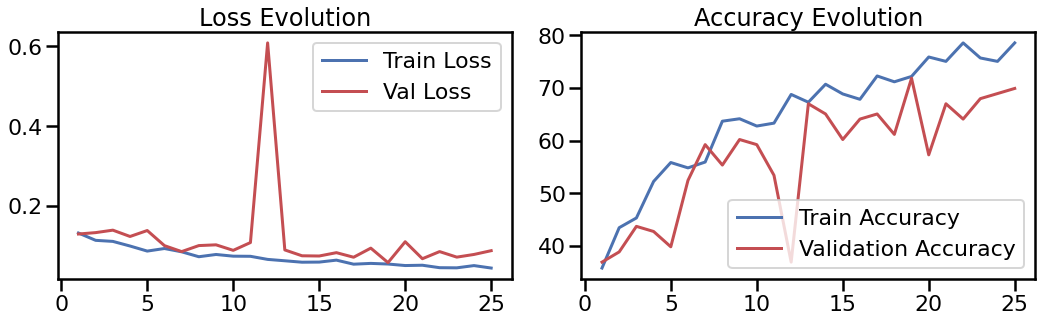

In [47]:
# Visual comparison
titles = ["Loss Evolution", "Accuracy Evolution"]
y = [[loss_train, loss_val], [acc_train, acc_val]]
label_loss = [['Train Loss', 'Val Loss'], ['Train Accuracy', 'Validation Accuracy']]
ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
steps = np.arange(1,26)
for idx, ax in enumerate(axes.flatten()):
    title = titles[idx]
    ax.plot(steps, y[idx][0], label=label_loss[idx][0], color='b')
    ax.plot(steps, y[idx][1], label=label_loss[idx][1], color='r')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()

### Unfreeze some layers

In [ ]:
names = [x for x,y in list(model_inception.named_parameters())]
names

In [ ]:
model_inc = inception_v3(pretrained=True)
i_max = len(names) - 29
i = 0
for param in model_inc.parameters():
  if i > i_max:
    break
  i += 1
  param.requires_grad = False
num_features = model_inc.fc.in_features
model_inc.fc = nn.Linear(num_features, 20)
model_inc.cuda()

In [58]:
param_optimizer = list(model_inc.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
lr = 0.001
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=lr)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
acc_train = []
loss_train = []
acc_val = []
loss_val = []
best_acc_val = 70
for epoch in range(1, 27):
    acc_t, loss_t = train(epoch, model_inc)
    acc_v, loss_v = validation(model_inc)
    if acc_v.item() > best_acc_val:
      model_file = orig_path + 'model_inception_retrained_' + str(acc_v.item()) + '.pth'
      best_acc_val = acc_v.item()
      torch.save(model_inc.state_dict(), model_file)
    acc_train.append(acc_t.item())
    loss_train.append(loss_t)
    acc_val.append(acc_v.item())
    loss_val.append(loss_v)

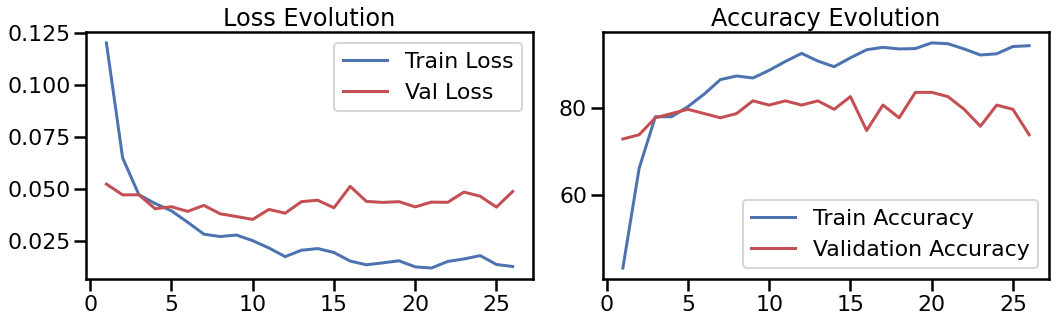

In [60]:
# Visual comparison
titles = ["Loss Evolution", "Accuracy Evolution"]
y = [[loss_train, loss_val], [acc_train, acc_val]]
label_loss = [['Train Loss', 'Val Loss'], ['Train Accuracy', 'Validation Accuracy']]
ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
steps = np.arange(1,27)
for idx, ax in enumerate(axes.flatten()):
    title = titles[idx]
    ax.plot(steps, y[idx][0], label=label_loss[idx][0], color='b')
    ax.plot(steps, y[idx][1], label=label_loss[idx][1], color='r')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()

## VGG19

In [61]:
from torchvision.models import vgg19

In [64]:
model_vgg.classifier[6].in_features

4096

### All Freeze

In [ ]:
model_vgg = vgg19(pretrained=True)
for param in model_vgg.parameters():
  param.requires_grad = False
num_features = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_features, 20)
model_vgg.cuda()

In [66]:
param_optimizer = list(model_vgg.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
lr = 0.001
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=lr)

criterion = torch.nn.CrossEntropyLoss()

In [67]:
def train(epoch, model):
    model.train()
    correct = 0
    loss_values = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
        loss_values += loss.data.item()
    avg_acc = 100*correct / len(train_loader.dataset)
    avg_loss = loss_values / len(train_loader.dataset)
    print(f'Average Accuracy : {avg_acc}')
    return (avg_acc, avg_loss)

def validation(model):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        validation_loss += criterion(output, target).data.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    avg_acc = 100. * correct / len(val_loader.dataset)
    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        avg_acc))
    return (avg_acc, validation_loss)

In [ ]:
acc_train = []
loss_train = []
acc_val = []
loss_val = []
best_acc_val = 70
for epoch in range(1, 26):
    acc_t, loss_t = train(epoch, model_vgg)
    acc_v, loss_v = validation(model_vgg)
    if acc_v.item() > best_acc_val:
      model_file = orig_path + 'model_vgg_' + str(acc_v.item()) + '.pth'
      best_acc_val = acc_v.item()
      torch.save(model_vgg.state_dict(), model_file)
    acc_train.append(acc_t.item())
    loss_train.append(loss_t)
    acc_val.append(acc_v.item())
    loss_val.append(loss_v)

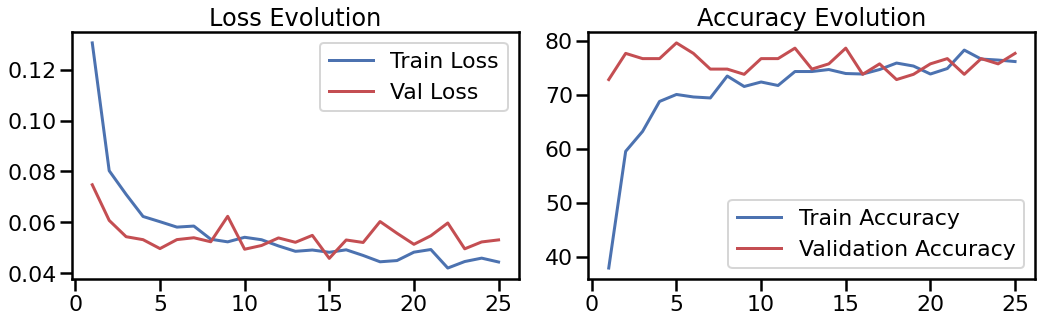

In [69]:
# Visual comparison
titles = ["Loss Evolution", "Accuracy Evolution"]
y = [[loss_train, loss_val], [acc_train, acc_val]]
label_loss = [['Train Loss', 'Val Loss'], ['Train Accuracy', 'Validation Accuracy']]
ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
steps = np.arange(1,26)
for idx, ax in enumerate(axes.flatten()):
    title = titles[idx]
    ax.plot(steps, y[idx][0], label=label_loss[idx][0], color='b')
    ax.plot(steps, y[idx][1], label=label_loss[idx][1], color='r')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()

### Unfreeze some layers

In [ ]:
names = [x for x,y in list(model_vgg.named_parameters())]
names

In [ ]:
model_vgg = vgg19(pretrained=True)
i_max = len(names) - 12
i = 0
for param in model_vgg.parameters():
  if i > i_max:
    break
  i += 1
  param.requires_grad = False
num_features = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_features, 20)
model_vgg.cuda()

In [78]:
param_optimizer = list(model_vgg.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
lr = 0.001
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=lr)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
acc_train = []
loss_train = []
acc_val = []
loss_val = []
best_acc_val = 70
for epoch in range(1, 26):
    acc_t, loss_t = train(epoch, model_vgg)
    acc_v, loss_v = validation(model_vgg)
    if acc_v.item() > best_acc_val:
      model_file = orig_path + 'model_vgg_retrained' + str(acc_v.item()) + '.pth'
      best_acc_val = acc_v.item()
      torch.save(model_vgg.state_dict(), model_file)
    acc_train.append(acc_t.item())
    loss_train.append(loss_t)
    acc_val.append(acc_v.item())
    loss_val.append(loss_v)

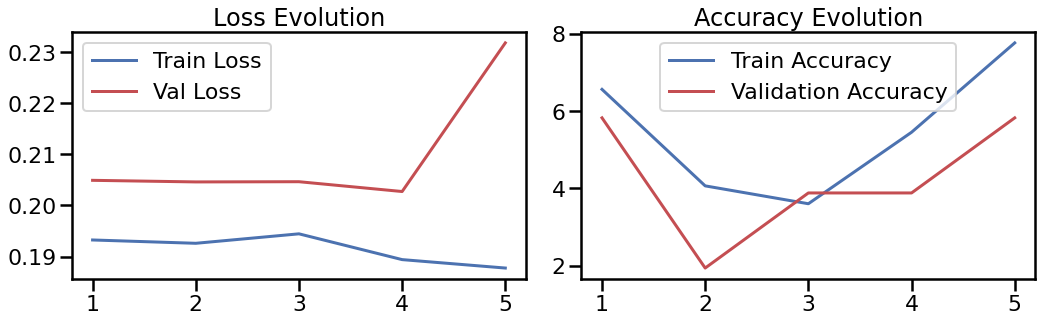

In [83]:
titles = ["Loss Evolution", "Accuracy Evolution"]
y = [[loss_train, loss_val], [acc_train, acc_val]]
label_loss = [['Train Loss', 'Val Loss'], ['Train Accuracy', 'Validation Accuracy']]
ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
steps = np.arange(1,len(loss_train)+1)
for idx, ax in enumerate(axes.flatten()):
    title = titles[idx]
    ax.plot(steps, y[idx][0], label=label_loss[idx][0], color='b')
    ax.plot(steps, y[idx][1], label=label_loss[idx][1], color='r')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()